In [1]:
!pip install optuna

In [2]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from torch import optim, nn
from tqdm import tqdm

from torchsummary import summary


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import optuna

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import zipfile


file = '/content/drive/MyDrive/natasha/miem-hse-ais-2024-lab-02.zip'
z = zipfile.ZipFile(file, "r")
z.extractall('/content/drive/MyDrive/natasha/miem-hse-ais-2024-lab-02/')

In [6]:
base = '/content/drive/MyDrive/natasha/miem-hse-ais-2024-lab-02/'

data = pd.read_csv(base + 'train.csv')
test_df = pd.read_csv(base + 'test.csv')
sub = pd.read_csv(base + 'sample_submission.csv')
data.head()

,review_id,movie_id,text,label
0,0,0,\nСтарая поговорка гласит: «Лучшие рассказы — ...,Good
1,1,0,"\nСамое сильное кино начала этого года, или ко...",Good
2,2,0,\nДушевно. Когда противоположности встречаются...,Good
3,3,0,"\nОб этом фильме я вообще ничего не знал, но н...",Good
4,4,0,"\nКак правило, история людей, которые прикован...",Good


In [7]:
test_df.head()

,review_id,text
0,0,"\n Если честно, досмотреть фильм до конца..."
1,1,\n «Новые приключения Алёнушки и Ерёмы»\n...
2,2,"\nМетель за окном, хочется чего то такого очен..."
3,3,\nУже множество лестных слов было сказано в ад...
4,4,"\nПрекрасный, печальный, добрый и в то же врем..."


In [8]:
data[data['label'].notna()].count()

,0
review_id,16784
movie_id,16784
text,16784
label,16784


In [9]:
mask = {'Good': 1, 'Bad': 0}
data['label'] = data['label'].map(mask)
data.head()

,review_id,movie_id,text,label
0,0,0,\nСтарая поговорка гласит: «Лучшие рассказы — ...,1
1,1,0,"\nСамое сильное кино начала этого года, или ко...",1
2,2,0,\nДушевно. Когда противоположности встречаются...,1
3,3,0,"\nОб этом фильме я вообще ничего не знал, но н...",1
4,4,0,"\nКак правило, история людей, которые прикован...",1


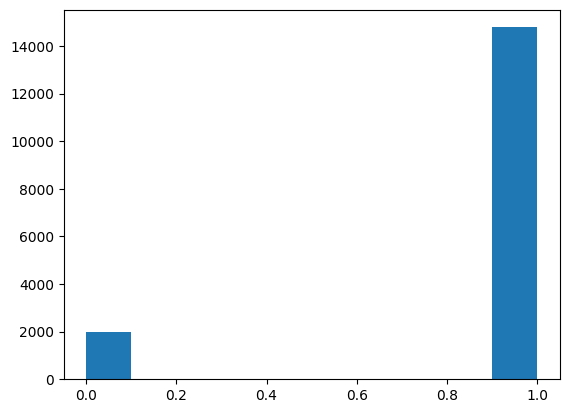

In [10]:
plt.hist(data.label, stacked=True)
plt.show()

In [11]:
train_df, valid_df = train_test_split(data, train_size=0.8, random_state=42, stratify=data.label)

In [12]:
train = train_df[train_df['label'] == 1].count() / train_df[train_df['label'] == 0].count()
valid = valid_df[valid_df['label'] == 1].count() / valid_df[valid_df['label'] == 0].count()
train, valid

(review_id    7.397123
 movie_id     7.397123
 text         7.397123
 label        7.397123
 dtype: float64,
 review_id    7.3925
 movie_id     7.3925
 text         7.3925
 label        7.3925
 dtype: float64)

In [13]:
class_weights_dict = {0: 7.4, 1: 1.0}
class_weights = torch.tensor([class_weights_dict[0],
                              class_weights_dict[1]],
                             dtype=torch.float
                ).to(device)

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
class MovieReviewDataset(Dataset):
    def __init__(self, reviews, labels=None, max_len=512):
        self.reviews = reviews
        self.max_len = max_len
        self.labels = labels

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        inputs = tokenizer(review, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_len)
        if self.labels is not None:
            label = self.labels[idx]
            return {**inputs, 'labels': torch.tensor(label, dtype=torch.long).unsqueeze(0)}  # Добавляем размерность
        return inputs

In [16]:
def get_dataloaders(train_dataset, val_dataset, batch_size=16):
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size)

  return train_loader, val_loader

In [25]:
def fit(model, optimizer, criterion, train_loader, val_loader, epochs, batch_size=16):
  total_steps = epochs * batch_size
  # scheduler = get_linear_schedule_with_warmup(optimizer,
  #                                             num_warmup_steps=0,
  #                                             num_training_steps=total_steps
  # )

  for epoch in range(epochs):  # Количество эпох
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = {key: val.squeeze(1).to(device) for key, val in batch.items()}
        # print(inputs)
        outputs = model(**inputs)

        # loss = outputs.loss

        logits = outputs.logits
        loss = criterion(logits, inputs['labels'])

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        # scheduler.step()

    # Валидация
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.squeeze(1).to(device) for key, val in batch.items()}
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(inputs['labels'].cpu().numpy())

    mcc = matthews_corrcoef(val_labels, val_preds)
    print(f'Epoch {epoch + 1}, MCC: {mcc}')

  return mcc

In [18]:
def test():
  model.eval()
  test_preds = []
  with torch.no_grad():
      for batch in test_loader:
          inputs = {key: val.squeeze(1).to(device) for key, val in batch.items()}
          outputs = model(**inputs)
          preds = torch.argmax(outputs.logits, dim=1)
          test_preds.extend(preds.cpu().numpy())

In [19]:
def plot_training(train_losses, valid_losses, valid_accuracies):
  plt.figure(figsize=(12, 9))
  plt.subplot(2, 1, 1)
  plt.xlabel('epoch')
  plt.plot(train_losses[1:], label='train_loss')
  plt.plot(valid_losses[1:], label='valid_loss')
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.xlabel('epoch')
  plt.plot(valid_accuracies, label='Mean Realative Error')
  plt.legend()

In [26]:
EPOCHS = 3
BATCH_SIZE = 16
LR = 1e-5
MAX_LEN = 512

In [27]:
train_dataset = MovieReviewDataset(train_df['text'].tolist(), train_df['label'].tolist(), max_len=MAX_LEN)
val_dataset = MovieReviewDataset(valid_df['text'].tolist(), valid_df['label'].tolist(),  max_len=MAX_LEN)
test_dataset = MovieReviewDataset(test_df['text'].tolist(), max_len=MAX_LEN)

In [28]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=2
)

# optimizer = optim.AdamW(model.parameters(), lr=1e-5)
optimizer = optim.AdamW(params=model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(weight=class_weights)

model.to(device)
print(sum(p.numel() for p in model.parameters()))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


177854978


In [ ]:
train_dl, val_dl = get_dataloaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)
fit(model, optimizer, criterion, train_dl, val_dl, epochs=EPOCHS, batch_size=BATCH_SIZE)

100%|██████████| 840/840 [20:58<00:00,  1.50s/it]


Epoch 1, MCC: 0.6727283111153539


100%|██████████| 840/840 [20:58<00:00,  1.50s/it]


In [ ]:
y_true = [1, 0, 1, 0, 1, 1, 0]
y_pred= [1, 1, 1, 1, 1, 1, 0]
matthews_corrcoef(y_true, y_pred)

In [ ]:
def objective(trial):
  max_len = trial.suggest_int('max_len', 256, 512)
  batch_size = trial.suggest_int('batch_size', 16, 32)
  learning_rate = trial.suggest_float('learning_rate', 1e-5, 0.5, log=True)
  epochs = trial.suggest_int('epochs', 3, 5)

  train_dataset = MovieReviewDataset(train_df['text'].tolist(), train_df['label'].tolist(), max_len=max_len)
  val_dataset = MovieReviewDataset(valid_df['text'].tolist(), valid_df['label'].tolist(),  max_len=max_len)
  test_dataset = MovieReviewDataset(test_df['text'].tolist(), max_len=max_len)

  model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-multilingual-cased',
    num_labels=2
  )

  optimizer = optim.AdamW(params=model.parameters(), lr=learning_rate)

  model.to(device)

  train_dl, val_dl = get_dataloaders(train_dataset, val_dataset, batch_size=batch_size)
  mcc = fit(model, optimizer, train_dl, val_dl, epochs=epochs, batch_size=batch_size)

  return mcc



In [ ]:
study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=10)

best_params = study.best_params
print("Лучшие параметры:", best_params)

In [ ]:
test_preds = test()

In [ ]:
submission_df = pd.DataFrame({
    'review_id': test_df['review_id'],
    'positive': test_preds
})
submission_df.to_csv('sample_submission.csv', index=False)

In [ ]:
# BERT
# EPOCHS = 5 BATCH_SIZE = 64 LR = 1e-5 MAX_LEN = 32, mcc = 0.33
# EPOCHS = 5 BATCH_SIZE = 32 LR = 1e-5 MAX_LEN = 64, mcc = 0.44
# EPOCHS = 3 BATCH_SIZE = 16 LR = 1e-5 MAX_LEN = 256, mcc = 0.63